# Recurrent Neural Networks | LSTM Price Movement Predictions For Trading Algorithms


In [15]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pandas_datareader import data as web
import yfinance as yf
import seaborn as sb
import tensorflow
import pandas_ta as ta

# 1. Gathering Data

In [117]:
tickers = ["BBAS3.SA"]
yf.pdr_override()
start_date = "2020-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')
data = web.get_data_yahoo(tickers, start=start_date, end=end_date)
data.head()
data.shape[0]
# %%
#Segmentando Dataframe para obter valores de interesse
data_close = pd.DataFrame(data["Adj Close"])
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,53.349998,53.970001,53.169998,53.799999,41.224869,13159900
2020-01-03,53.099998,53.910000,52.849998,53.709999,41.155910,9465400
2020-01-06,53.400002,53.400002,52.450001,53.000000,40.611866,9999900
2020-01-07,53.000000,53.029999,52.290001,52.599998,40.305359,10638500
2020-01-08,52.759998,52.990002,52.040001,52.119999,39.937546,21468600


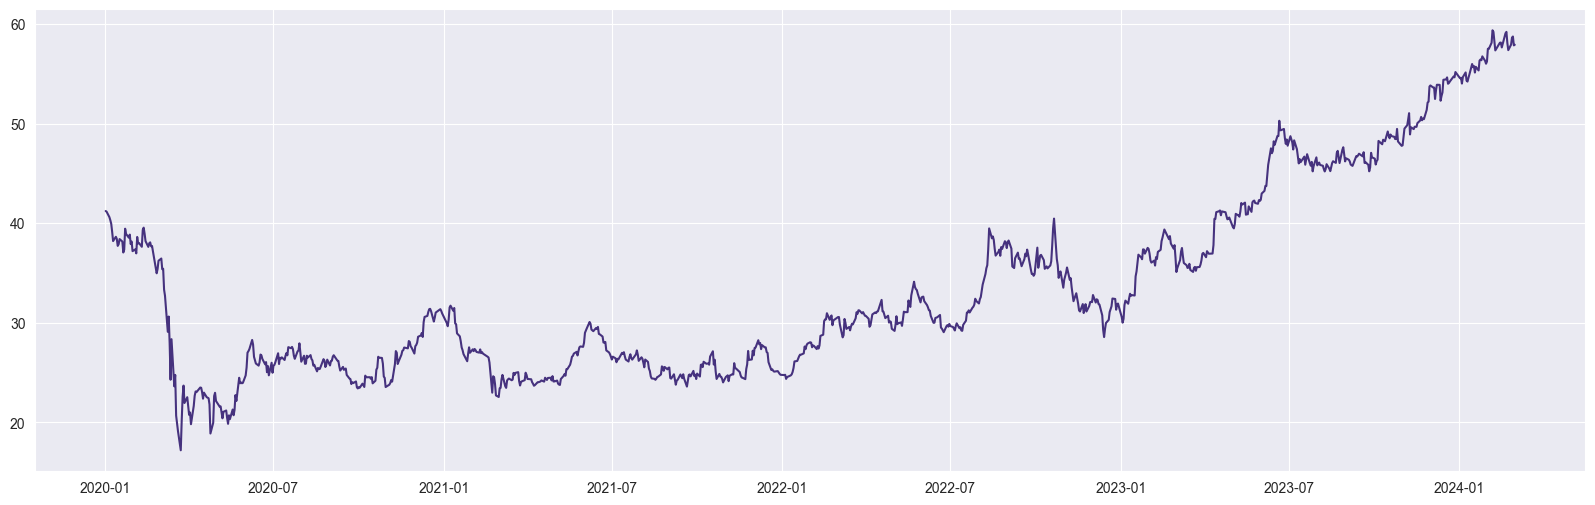

In [96]:
sb.set_palette('viridis')
sb.set_style('darkgrid')
plt.figure(figsize=(20,6))
plt.plot(data_close.index, data_close['Adj Close'])
plt.show()

# 2. Data Treatment

In [11]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

# 3. Data Analysis

In [118]:
data['RSI'] = ta.rsi(data.Close, length=15)
data['EMAFast'] = ta.rsi(data.Close, length=20)
data['EMAMedium'] = ta.rsi(data.Close, length=100)
data['EMASlow'] = ta.rsi(data.Close, length=150)

data['Target'] = data['Adj Close'] - data.Open
data['Target'] = data['Target'].shift(-1) #To get next day target value.

data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]
data['TargetNextClose'] = data['Adj Close'].shift(-1)

data.dropna(inplace=True)
#data.set_index = data['Date']
#data.reset_index(inplace=True)
data.drop(['Volume', 'Close'], axis=1, inplace=True)
data_set = data.iloc[:, 0:11] #
pd.set_option('display.max_columns', None)
data_set.head()

C:\Users\z004s8rp\AppData\Local\Temp\ipykernel_35772\3955654931.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]


,Open,High,Low,Adj Close,RSI,EMAFast,EMAMedium,EMASlow,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,
2020-08-07,34.000000,34.939999,33.599998,26.505211,50.238833,51.026721,46.824639,45.852613,-7.366138,0,26.753860
2020-08-10,34.119999,34.599998,33.750000,26.753860,51.878577,52.182018,47.051461,46.034815,-8.234661,0,26.365337
2020-08-11,34.599998,34.889999,33.900002,26.365337,49.166284,50.232980,46.736818,45.792436,-7.774532,0,26.225468
2020-08-12,34.000000,34.419998,33.200001,26.225468,48.194407,49.531906,46.623442,45.705223,-8.192926,0,25.697073
2020-08-13,33.889999,34.400002,33.049999,25.697073,44.624045,46.927465,46.195818,45.376554,-7.317450,0,25.782549


In [120]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)
print(data_set_scaled)

[[0.20392277 0.20325459 0.20536822 ... 0.20210392 0.         0.11417245]
 [0.20765873 0.19240583 0.21004992 ... 0.12235574 0.         0.10362217]
 [0.22260268 0.20165921 0.21473161 ... 0.16460499 0.         0.09982404]
 ...
 [0.95703608 0.9629866  0.96691631 ... 0.89407565 1.         0.98302232]
 [0.96917815 0.97543074 0.97971281 ... 0.79674616 0.         0.95885454]
 [0.97447074 0.96841092 0.95755304 ... 0.87571148 0.         0.96048376]]


In [121]:
X = []
backcandles = 10 #Number of days we wanna to look back in the past to predict next closing price day.
print(data_set_scaled.shape[0])
for j in range(8):
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-backcandles:i, j])
X = np.moveaxis(X, [0], [2])
X, yi = np.array(X), np.array(data_set_scaled[backcandles:,-1])
y = np.reshape(yi, (len(yi), 1))

print(X.shape)
print(y.shape)

884
(874, 10, 8)
(874, 1)


# 4. RNN Models

In [152]:
splitlimit_test = int(len(X) * 0.9)
splitlimit_val = int(len(X) * 0.8)

X_train, X_val, X_test = X[:splitlimit_val], X[splitlimit_val:splitlimit_test], X[splitlimit_test:]
y_train, y_val, y_test = y[:splitlimit_val], y[splitlimit_val:splitlimit_test], y[splitlimit_test:]

data_train, data_val, data_test = data[:splitlimit_val].index, data[splitlimit_val:splitlimit_test].index, data[splitlimit_test:].index
data_train.shape, data_val.shape, data_test.shape

((699,), (87,), (98,))

In [61]:
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed
from tensorflow.keras import layers

import tensorflow as tf
import keras
from keras.callbacks import History
from keras.layers import LSTM, Input, Activation, concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# 4.1. LSTM

In [160]:
model = Sequential([layers.Input((backcandles, 8)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

In [161]:
model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

In [162]:
model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val))
model.summary()
# %%

Epoch 1/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0113 - mean_absolute_error: 0.0744 - val_loss: 0.0094 - val_mean_absolute_error: 0.0866
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023 - mean_absolute_error: 0.0374 - val_loss: 0.0055 - val_mean_absolute_error: 0.0656
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - mean_absolute_error: 0.0273 - val_loss: 7.1606e-04 - val_mean_absolute_error: 0.0219
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - mean_absolute_error: 0.0269 - val_loss: 8.1285e-04 - val_mean_absolute_error: 0.0209
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010 - mean_absolute_error: 0.0235 - val_loss: 7.9464e-04 - val_mean_absolute_error: 0.0210
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.7425e-04 - mean_absolute_error: 0.0220 - val_loss: 8.0362e-04 - val_mean_absolute_error: 0.0215
Epoch 7/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.1328e-04 - mean_absolute_

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 64)                  │          18,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,405 (243.77 KB)

 Trainable params: 20,801 (81.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,604 (162.52 KB)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


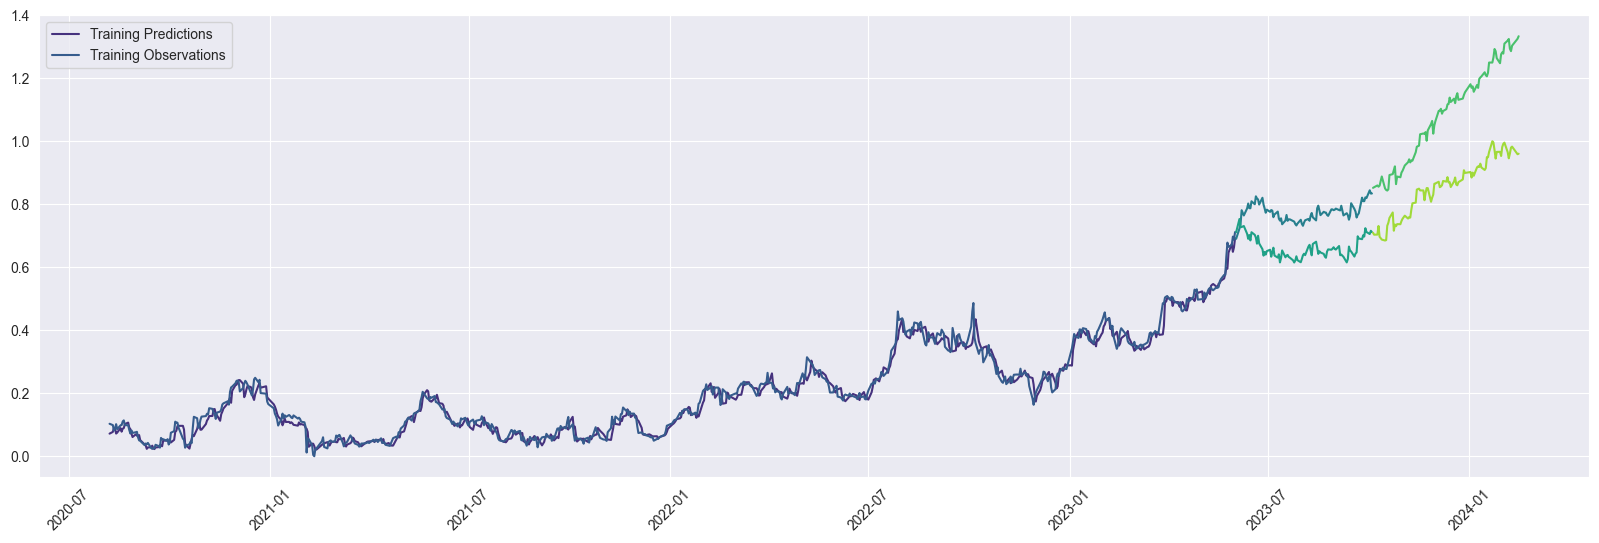

In [163]:
train_predictions = model.predict(X_train).flatten()
val_predictions = model.predict(X_val).flatten()
test_predictions = model.predict(X_test).flatten()



plt.figure(figsize=(20,6))
plt.plot(data_train, train_predictions)
plt.plot(data_train, y_train)

plt.plot(data_val, val_predictions)
plt.plot(data_val, y_val)

plt.plot(data_test[:-10], test_predictions)
plt.plot(data_test[:-10], y_test)

plt.legend(['Training Predictions', 'Training Observations'])
plt.tick_params(axis='x', rotation=45)

# 4.2. GRU

In [164]:
model = Sequential([layers.Input((backcandles, 8)),
                    layers.GRU(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

In [165]:
model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

In [166]:
model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val))
model.summary()
# %%

Epoch 1/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0569 - mean_absolute_error: 0.1650 - val_loss: 0.0728 - val_mean_absolute_error: 0.2660
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - mean_absolute_error: 0.0430 - val_loss: 0.0055 - val_mean_absolute_error: 0.0643
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - mean_absolute_error: 0.0317 - val_loss: 0.0025 - val_mean_absolute_error: 0.0400
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - mean_absolute_error: 0.0284 - val_loss: 0.0020 - val_mean_absolute_error: 0.0357
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - mean_absolute_error: 0.0254 - val_loss: 0.0016 - val_mean_absolute_error: 0.0319
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.9909e-04 - mean_absolute_error: 0.0238 - val_loss: 0.0016 - val_mean_absolute_error: 0.0322
Epoch 7/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.6614e-04 - mean_absolute_error: 0.0234 -

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, 64)                  │          14,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,965 (191.27 KB)

 Trainable params: 16,321 (63.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 32,644 (127.52 KB)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


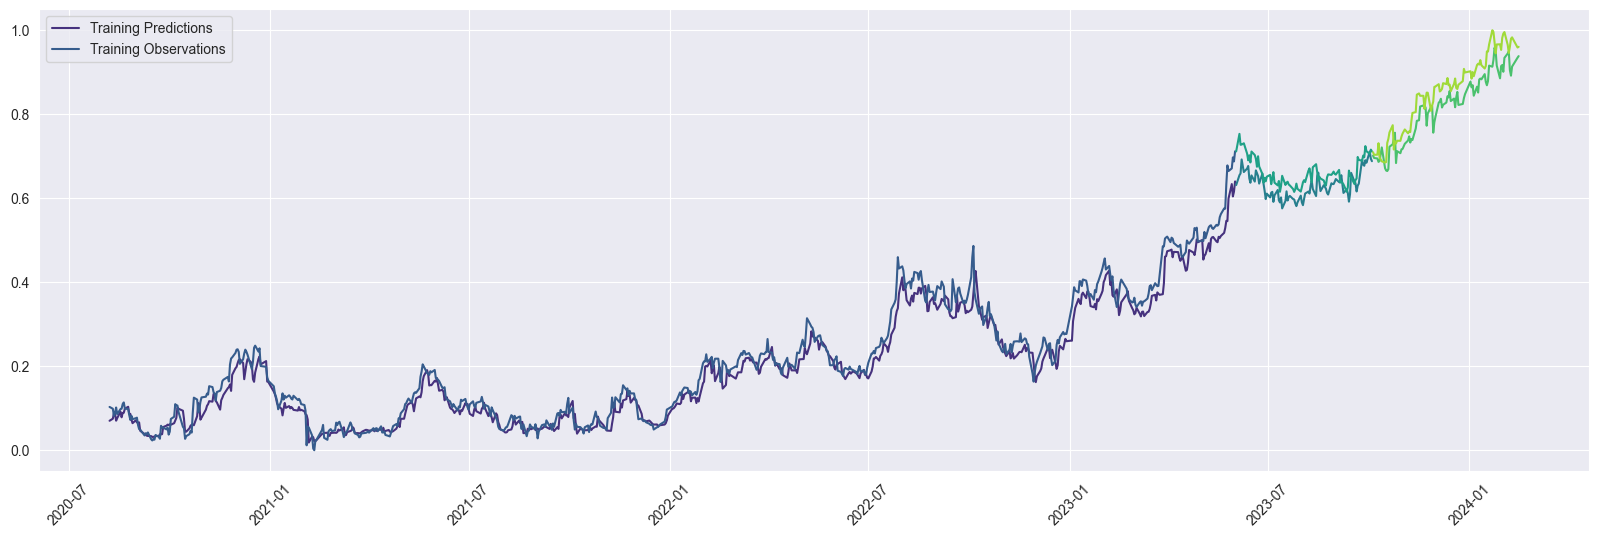

In [167]:
train_predictions = model.predict(X_train).flatten()
val_predictions = model.predict(X_val).flatten()
test_predictions = model.predict(X_test).flatten()



plt.figure(figsize=(20,6))
plt.plot(data_train, train_predictions)
plt.plot(data_train, y_train)

plt.plot(data_val, val_predictions)
plt.plot(data_val, y_val)

plt.plot(data_test[:-10], test_predictions)
plt.plot(data_test[:-10], y_test)

plt.legend(['Training Predictions', 'Training Observations'])
plt.tick_params(axis='x', rotation=45)